[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# snnTorch - Surrogate Gradient Descent in a Convolutional Spiking Neural Network
## Tutorial 6
### By Jason K. Eshraghian (www.ncg.ucsc.edu)

<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_6_CNN.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub-Mark-Light-120px-plus.png?raw=true' width="28">](https://github.com/jeshraghian/snntorch/) [<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/GitHub_Logo_White.png?raw=true' width="80">](https://github.com/jeshraghian/snntorch/)

## Edited by Twenkid, added also Kokoro (TTS, 2025)

The snnTorch tutorial series is based on the following paper. If you find these resources or code useful in your work, please consider citing the following source:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". Proceedings of the IEEE, 111(9) September 2023.](https://ieeexplore.ieee.org/abstract/document/10242251) </cite>


# Introduction
In this tutorial, you will:
* Learn how to modify surrogate gradient descent to overcome the dead neuron problem
* Construct and train a convolutional spiking neural network
* Use a sequential container, `nn.Sequential` to simplify model construction

Part of this tutorial was inspired by Friedemann Zenke’s extensive
work on SNNs. Check out his repo on surrogate gradients
[here](https://github.com/fzenke/spytorch), and a favourite paper
of mine: E. O. Neftci, H. Mostafa, F. Zenke, [Surrogate Gradient
Learning in Spiking Neural Networks: Bringing the Power of
Gradient-based optimization to spiking neural
networks.](https://ieeexplore.ieee.org/document/8891809) IEEE
Signal Processing Magazine 36, 51–63.

At the end of the tutorial, we will train a convolutional spiking neural network (CSNN) using the MNIST dataset to perform image classification. The background theory follows on from [Tutorials 2, 4 and 5](https://snntorch.readthedocs.io/en/latest/tutorials/index.html), so feel free to go back if you need to brush up.

If running in Google Colab:
* You may connect to GPU by checking `Runtime` > `Change runtime type` > `Hardware accelerator: GPU`
* Next, install the latest PyPi distribution of snnTorch by clicking into the following cell and pressing `Shift+Enter`.

In [1]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 9.4 MB/s eta 0:00:00


In [2]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

<ipython-input-2-bd886847109b>:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


# 1. Surrogate Gradient Descent

[Tutorial 5](https://snntorch.readthedocs.io/en/latest/tutorials/index.html) raised the **dead neuron problem**. This arises because of the non-differentiability of spikes:


$$S[t] = \Theta(U[t] - U_{\rm thr}) \tag{1}$$
$$\frac{\partial S}{\partial U} = \delta(U - U_{\rm thr}) \in \{0, \infty\} \tag{2}$$

where $\Theta(\cdot)$ is the Heaviside step function, and $\delta(\cdot)$ is the Dirac-Delta function. We previously overcame this using the gradient of the threshold-shifted *ArcTangent* function on the backward pass instead.

Other common smoothing functions include the sigmoid function, or the fast sigmoid function. The sigmoidal functions must also be shifted such that they are centered at the threshold $U_{\rm thr}$. Defining  the overdrive of the membrane potential as $U_{OD} = U - U_{\rm thr}$:

$$\tilde{S} = \frac{U_{OD}}{1+k|U_{OD}|} \tag{3}$$
$$\frac{\partial \tilde{S}}{\partial U} = \frac{1}{(k|U_{OD}|+1)^2}\tag{4}$$

where $k$ modulates how smooth the surrogate function is, and is treated as a hyperparameter. As $k$ increases, the approximation converges towards the original derivative in $(2)$:  

$$\frac{\partial \tilde{S}}{\partial U} \Bigg|_{k \rightarrow \infty} = \delta(U-U_{\rm thr})$$


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial6/surrogate.png?raw=true' width="800">
</center>

To summarize:

* **Forward Pass**
  - Determine $S$ using the shifted Heaviside function in $(1)$
  - Store $U$ for later use during the backward pass
* **Backward Pass**
  - Pass $U$ into $(4)$ to calculate the derivative term

In the same way the *ArcTangent* approach was used in [Tutorial 5](https://snntorch.readthedocs.io/en/latest/tutorials/index.html),
the gradient of the fast sigmoid function can override the Dirac-Delta function in a Leaky Integrate-and-Fire
(LIF) neuron model:

In [3]:
# Leaky neuron model, overriding the backward pass with a custom function
class LeakySigmoidSurrogate(nn.Module):
  def __init__(self, beta, threshold=1.0, k=25):

      # Leaky_Surrogate is defined in the previous tutorial and not used here
      super(Leaky_Surrogate, self).__init__()

      # initialize decay rate beta and threshold
      self.beta = beta
      self.threshold = threshold
      self.surrogate_func = self.FastSigmoid.apply

  # the forward function is called each time we call Leaky
  def forward(self, input_, mem):
    spk = self.surrogate_func((mem-self.threshold))  # call the Heaviside function
    reset = (spk - self.threshold).detach()
    mem = self.beta * mem + input_ - reset
    return spk, mem

  # Forward pass: Heaviside function
  # Backward pass: Override Dirac Delta with gradient of fast sigmoid
  @staticmethod
  class FastSigmoid(torch.autograd.Function):
    @staticmethod
    def forward(ctx, mem, k=25):
        ctx.save_for_backward(mem) # store the membrane potential for use in the backward pass
        ctx.k = k
        out = (mem > 0).float() # Heaviside on the forward pass: Eq(1)
        return out

    @staticmethod
    def backward(ctx, grad_output):
        (mem,) = ctx.saved_tensors  # retrieve membrane potential
        grad_input = grad_output.clone()
        grad = grad_input / (ctx.k * torch.abs(mem) + 1.0) ** 2  # gradient of fast sigmoid on backward pass: Eq(4)
        return grad, None

Better yet, all of that can be condensed by using the built-in module `snn.surrogate` from snnTorch, where $k$ from $(4)$ is denoted `slope`. The surrogate gradient is passed into `spike_grad` as an argument:

In [4]:
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5

lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)

To explore the other surrogate gradient functions available, [take a look at the documentation here.](https://snntorch.readthedocs.io/en/latest/snntorch.surrogate.html)

# 2. Setting up the CSNN
## 2.1 DataLoaders

In [5]:
# dataloader arguments
batch_size = 128
data_path='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.55MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 64.9kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.36MB/s]


## 2.2 Define the Network

The convolutional network architecture to be used is: 12C5-MP2-64C5-MP2-1024FC10

- 12C5 is a 5$\times$5 convolutional kernel with 12 filters
- MP2 is a 2$\times$2 max-pooling function
- 1024FC10 is a fully-connected layer that maps 1,024 neurons to 10 outputs

In [7]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = 50

In [8]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc1 = nn.Linear(64*4*4, 10)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        cur1 = F.max_pool2d(self.conv1(x), 2)
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool2d(self.conv2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)

        cur3 = self.fc1(spk2.view(batch_size, -1))
        spk3, mem3 = self.lif3(cur3, mem3)
        return spk3, mem3

In the previous tutorial, the network was wrapped inside of a class, as shown above.
With increasing network complexity, this adds a lot of boilerplate code that we might wish to avoid. Alternatively, the `nn.Sequential` method can be used instead.

> Note: the following code-block simulates over one single time-step, and requires a separate for-loop over time.

In [9]:
#  Initialize Network
net = nn.Sequential(nn.Conv2d(1, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 64, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(64*4*4, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)


The `init_hidden` argument initializes the hidden states of the neuron (here, membrane potential). This takes place in the background as an instance variable.
If `init_hidden` is activated, the membrane potential is not explicitly returned to the user, ensuring only the output spikes are sequentially passed through the layers wrapped in `nn.Sequential`.

To train a model using the final layer's membrane potential, set the argument `output=True`.
This enables the final layer to return both the spike and membrane potential response of the neuron.

## 2.3 Forward-Pass
A forward pass across a simulation duration of `num_steps` looks like this:

In [10]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

for step in range(num_steps):
    spk_out, mem_out = net(data)

Wrap that in a function, recording the membrane potential and spike response over time:

In [11]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [12]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

# 3. Training Loop

## 3.1 Loss Using snn.Functional

In the previous tutorial, the Cross Entropy Loss between the membrane potential of the output neurons and the target was used to train the network.
This time, the total number of spikes from each neuron will be used to calculate the Cross Entropy instead.

A variety of loss functions are included in the `snn.functional` module, which is analogous to `torch.nn.functional` in PyTorch.
These implement a mix of cross entropy and mean square error losses, are applied to spikes and/or membrane potential, to train a rate or latency-coded network.

The approach below applies the cross entropy loss to the output spike count in order train a rate-coded network:

In [13]:
# already imported snntorch.functional as SF
loss_fn = SF.ce_rate_loss()

The recordings of the spike are passed as the first argument to `loss_fn`, and the target neuron index as the second argument to generate a loss. [The documentation provides further information and exmaples.](https://snntorch.readthedocs.io/en/latest/snntorch.functional.html#snntorch.functional.ce_rate_loss)

In [14]:
loss_val = loss_fn(spk_rec, targets)

print(f"The loss from an untrained network is {loss_val.item():.3f}")

The loss from an untrained network is 2.303


## 3.2 Accuracy Using snn.Functional
The `SF.accuracy_rate()` function works similarly, in that the predicted output spikes and actual targets are supplied as arguments. `accuracy_rate` assumes a rate code is used to interpret the output by checking if the index of the neuron with the highest spike count matches the target index.

In [15]:
acc = SF.accuracy_rate(spk_rec, targets)

print(f"The accuracy of a single batch using an untrained network is {acc*100:.3f}%")

The accuracy of a single batch using an untrained network is 10.938%


As the above function only returns the accuracy of a single batch of data, the following function returns the accuracy on the entire DataLoader object:

In [16]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [17]:
test_acc = batch_accuracy(test_loader, net, num_steps)

print(f"The total accuracy on the test set is: {test_acc * 100:.2f}%")

The total accuracy on the test set is: 9.81%


## 3.3 Training Loop

The following training loop is qualitatively similar to the previous tutorial.

In [18]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 1
loss_hist = []
test_acc_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):

    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter % 50 == 0:
          with torch.no_grad():
              net.eval()

              # Test set forward pass
              test_acc = batch_accuracy(test_loader, net, num_steps)
              print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
              test_acc_hist.append(test_acc.item())

        counter += 1

Iteration 0, Test Acc: 9.82%

Iteration 50, Test Acc: 92.25%

Iteration 100, Test Acc: 95.69%

Iteration 150, Test Acc: 95.75%

Iteration 200, Test Acc: 97.41%

Iteration 250, Test Acc: 97.18%

Iteration 300, Test Acc: 97.41%

Iteration 350, Test Acc: 97.67%

Iteration 400, Test Acc: 97.87%

Iteration 450, Test Acc: 97.92%



Despite having selected some fairly generic values and architectures, the test set accuracy should be fairly competitive given the brief training run!

# 4. Results
## 4.1 Plot Test Accuracy

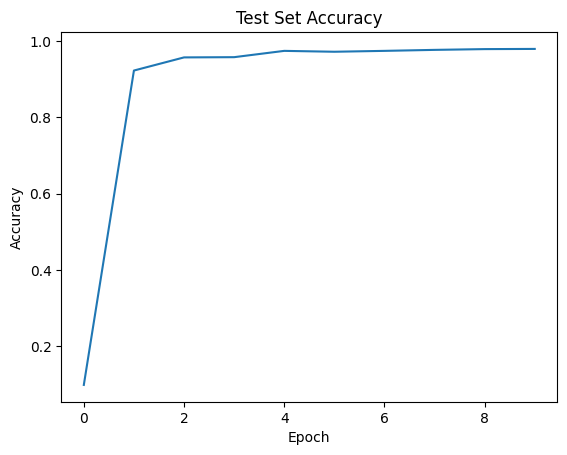

In [19]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## 4.2 Spike Counter

Run a forward pass on a batch of data to obtain spike and membrane readings.

In [20]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

Changing `idx` allows you to index into various samples from the simulated minibatch. Use `splt.spike_count` to explore the spiking behaviour of a few different samples!

> Note: if you are running the notebook locally on your desktop, please uncomment the line below and modify the path to your ffmpeg.exe



The target label is: 2


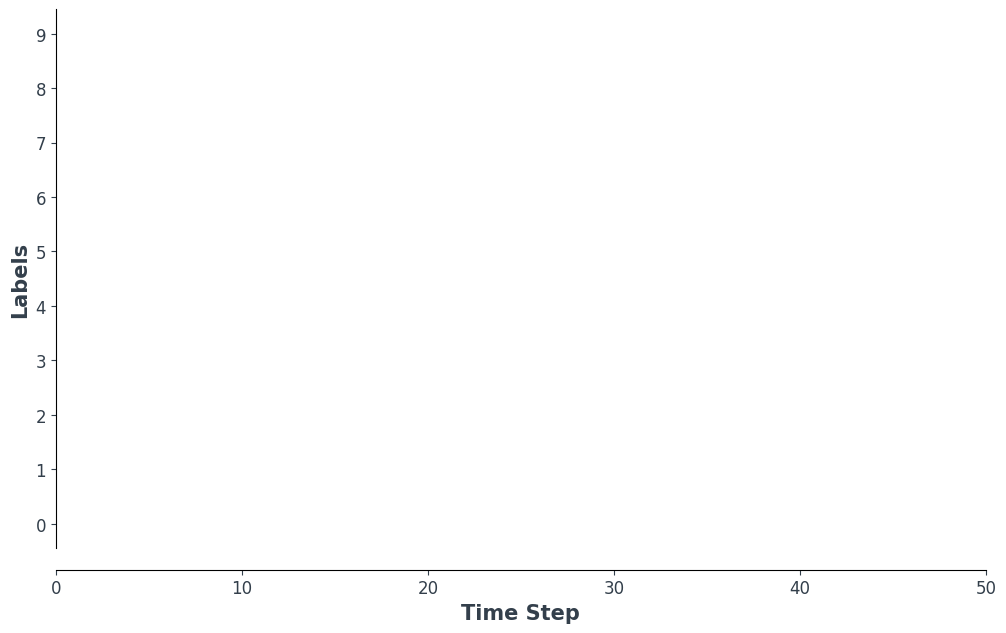

In [21]:
from IPython.display import HTML

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=4)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

# Conclusion
You should now have a grasp of the basic features of snnTorch and be able to start running your own experiments. [In the next tutorial](https://snntorch.readthedocs.io/en/latest/tutorials/index.html), we will train a network using a neuromorphic dataset.

A special thanks to [Gianfrancesco Angelini](https://github.com/gianfa) for providing valuable feedback on the tutorial.

If you like this project, please consider starring ⭐ the repo on GitHub as it is the easiest and best way to support it.

# Additional Resources
* [Check out the snnTorch GitHub project here.](https://github.com/jeshraghian/snntorch)

In [35]:
!pip install tonic snntorch
#pip install snntorch

In [33]:
!pip install tonic
!pip install snntorch

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4


In [31]:
!pip install numpy --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 93.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tonic 1.6.0 requires numpy<2.0.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.


In [1]:
import tonic

dataset = tonic.datasets.NMNIST(save_to='./data', train=True)
events, target = dataset[0]

[(10, 30,    937, 1) (33, 20,   1030, 1) (12, 27,   1052, 1) ...
 ( 7, 15, 302706, 1) (26, 11, 303852, 1) (11, 17, 305341, 1)]


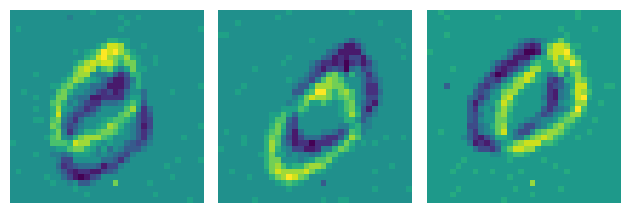

In [3]:
print(events)
tonic.utils.plot_event_grid(events)
import tonic.transforms as transforms

sensor_size = tonic.datasets.NMNIST.sensor_size

# Denoise removes isolated, one-off events
# time_window
frame_transform = transforms.Compose([transforms.Denoise(filter_time=10000),
                                      transforms.ToFrame(sensor_size=sensor_size,
                                                         time_window=1000)
                                     ])

trainset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.NMNIST(save_to='./data', transform=frame_transform, train=False)


In [4]:
from torch.utils.data import DataLoader
from tonic import DiskCachedDataset


cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/nmnist/train')
cached_dataloader = DataLoader(cached_trainset)

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors())
def load_sample_batched():
    events, target = next(iter(cached_dataloader))
%timeit -o -r 10 load_sample_batched()


5.92 ms ± 291 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


<TimeitResult : 5.92 ms ± 291 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)>

In [5]:
!pip install kokoro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of spacy-curated-transformers to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   

In [5]:
!pip install soundfile
!apt-get -qq -y install espeak-ng > /dev/null 2>&1
from kokoro import KPipeline
from IPython.display import display, Audio
import soundfile as sf
import torch
pipeline = KPipeline(lang_code='a')
text = '''
[Kokoro](/kˈOkəɹO/) is an open-weight TTS model with 82 million parameters. Despite its lightweight architecture, it delivers comparable quality to larger models while being significantly faster and more cost-efficient. With Apache-licensed weights, [Kokoro](/kˈOkəɹO/) can be deployed anywhere from production environments to personal projects.
'''
generator = pipeline(text, voice='af_heart')
for i, (gs, ps, audio) in enumerate(generator):
    print(i, gs, ps)
    display(Audio(data=audio, rate=24000, autoplay=i==0))
    sf.write(f'{i}.wav', audio, 24000)

config.json:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


kokoro-v1_0.pth:   0%|          | 0.00/327M [00:00<?, ?B/s]

af_heart.pt:   0%|          | 0.00/523k [00:00<?, ?B/s]

0 Kokoro is an open-weight TTS model with 82 million parameters. Despite its lightweight architecture, it delivers comparable quality to larger models while being significantly faster and more cost-efficient. With Apache-licensed weights, Kokoro can be deployed anywhere from production environments to personal projects. kˈOkəɹO ɪz ɐn ˈOpᵊnwˌAt tˌitˌiˈɛs mˈɑdᵊl wɪð ˈATi tˈu mˈɪljᵊn pəɹˈæməTəɹz. dəspˈIt ɪts lˈItwˌAt ˈɑɹkətˌɛkʧəɹ, ɪt dəlˈɪvəɹz kˈɑmpəɹəbᵊl kwˈɑləTi tə lˈɑɹʤəɹ mˈɑdᵊlz wˌIl bˈiɪŋ səɡnˈɪfəkəntli fˈæstəɹ ænd mˈɔɹ kˈɔstəfˌɪʃənt. wˌɪð əpˌæʧilˈIsᵊnst wˈAts, kˈOkəɹO kæn bi dəplˈYd ˈɛniwˌɛɹ fɹʌm pɹədˈʌkʃən ənvˈIɹənmᵊnts tə pˈɜɹsᵊnəl pɹˈɑʤˌɛkts.


In [9]:
text = "Tohvah eh nehvehrohyahtnoh! Kahkvo ymah? Svehshtenniyaht smehtahch."
generator = pipeline(text, voice='af_heart')
for i, (gs, ps, audio) in enumerate(generator):
    print(i, gs, ps)
    display(Audio(data=audio, rate=24000, autoplay=i==0))
    sf.write(f'{i}_bg3.wav', audio, 24000)

0 Tohvah eh nehvehrohyahtnoh! Kahkvo ymah? Svehshtenniyaht smehtahch. tˈOvə ˈA nˈAvAɹˌOɪˌɑtnO! kˈɑkvO ˈɪmə? svˈAʃtənˌɪjɑt smˈATɑʧ.


In [ ]:
generator = pipeline(text, voice='af_heart')
for i, (gs, ps, audio) in enumerate(generator):
    print(i, gs, ps)
    display(Audio(data=audio, rate=24000, autoplay=i==0))
    sf.write(f'{i}.wav', audio, 24000)

In [14]:
text = "Tohvah eh nehvehrohyahtnoh! Kahkvo ymah? Ssvehshtenniyaht smehtahch. Govoria dobur bulgarski ezzik."
pipeline = KPipeline(lang_code='i') # <= Italian make sure lang_code matches voice, reference above.
generator = pipeline(text, voice='af_heart')
for i, (gs, ps, audio) in enumerate(generator):
    print(i, gs, ps)
    display(Audio(data=audio, rate=24000, autoplay=i==0))
    sf.write(f'{i}_it2.wav', audio, 24000)

0 Tohvah eh nehvehrohyahtnoh! Kahkvo ymah? Ssvehshtenniyaht smehtahch. Govoria dobur bulgarski ezzik. tˈova ˈe neverojˈatno! kˈakvo ˈima? Sveʃtˈennjjat zmˈetaʧ. ɡovˈɔria dobˈur bʊlɡˈarskɪ ˈeʣːik.


In [6]:
from tonic import MemoryCachedDataset

cached_trainset = MemoryCachedDataset(trainset)
import torch
import torchvision

transform = tonic.transforms.Compose([torch.from_numpy,
                                      torchvision.transforms.RandomRotation([-10,10])])

cached_trainset = DiskCachedDataset(trainset, transform=transform, cache_path='./cache/nmnist/train')

# no augmentations for the testset
cached_testset = DiskCachedDataset(testset, cache_path='./cache/nmnist/test')

batch_size = 128
trainloader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False), shuffle=True)
testloader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=False))
event_tensor, target = next(iter(trainloader))
print(event_tensor.shape)


torch.Size([310, 128, 2, 34, 34])


Epoch 0, Iteration 0 
Train Loss: 31.00
Accuracy: 11.72%

Epoch 0, Iteration 1 
Train Loss: 30.90
Accuracy: 8.59%

Epoch 0, Iteration 2 
Train Loss: 31.00
Accuracy: 8.59%

Epoch 0, Iteration 3 
Train Loss: 30.90
Accuracy: 11.72%

Epoch 0, Iteration 4 
Train Loss: 21.80
Accuracy: 18.75%

Epoch 0, Iteration 5 
Train Loss: 12.76
Accuracy: 10.94%

Epoch 0, Iteration 6 
Train Loss: 16.87
Accuracy: 19.53%

Epoch 0, Iteration 7 
Train Loss: 16.63
Accuracy: 14.84%

Epoch 0, Iteration 8 
Train Loss: 14.70
Accuracy: 21.88%

Epoch 0, Iteration 9 
Train Loss: 12.01
Accuracy: 23.44%

Epoch 0, Iteration 10 
Train Loss: 15.34
Accuracy: 14.84%

Epoch 0, Iteration 11 
Train Loss: 15.22
Accuracy: 17.19%

Epoch 0, Iteration 12 
Train Loss: 12.29
Accuracy: 25.00%

Epoch 0, Iteration 13 
Train Loss: 11.74
Accuracy: 27.34%

Epoch 0, Iteration 14 
Train Loss: 13.03
Accuracy: 28.12%

Epoch 0, Iteration 15 
Train Loss: 13.52
Accuracy: 31.25%

Epoch 0, Iteration 16 
Train Loss: 12.05
Accuracy: 31.25%

Epoch 0, 

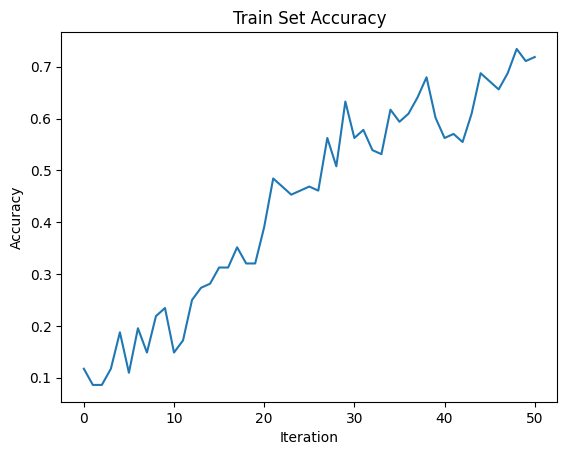

In [15]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

#  Initialize Network
net = nn.Sequential(nn.Conv2d(2, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 32, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)
# this time, we won't return membrane as we don't need it

def forward_pass(net, data):
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)
num_epochs = 1
num_iters = 50

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        # training loop breaks after 50 iterations
        if i == num_iters:
          break
import matplotlib.pyplot as plt

# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()


Epoch 0, Iteration 0 
Train Loss: 6.95
Accuracy: 70.31%

Epoch 0, Iteration 1 
Train Loss: 6.91
Accuracy: 68.75%

Epoch 0, Iteration 2 
Train Loss: 6.84
Accuracy: 71.88%

Epoch 0, Iteration 3 
Train Loss: 6.35
Accuracy: 78.12%

Epoch 0, Iteration 4 
Train Loss: 6.62
Accuracy: 71.88%

Epoch 0, Iteration 5 
Train Loss: 6.23
Accuracy: 77.34%

Epoch 0, Iteration 6 
Train Loss: 6.15
Accuracy: 78.12%

Epoch 0, Iteration 7 
Train Loss: 6.07
Accuracy: 79.69%

Epoch 0, Iteration 8 
Train Loss: 6.39
Accuracy: 77.34%

Epoch 0, Iteration 9 
Train Loss: 6.28
Accuracy: 77.34%

Epoch 0, Iteration 10 
Train Loss: 5.82
Accuracy: 82.81%

Epoch 0, Iteration 11 
Train Loss: 6.01
Accuracy: 74.22%

Epoch 0, Iteration 12 
Train Loss: 6.62
Accuracy: 74.22%

Epoch 0, Iteration 13 
Train Loss: 5.85
Accuracy: 78.91%

Epoch 0, Iteration 14 
Train Loss: 9.69
Accuracy: 70.31%

Epoch 0, Iteration 15 
Train Loss: 6.68
Accuracy: 75.78%

Epoch 0, Iteration 16 
Train Loss: 7.41
Accuracy: 72.66%

Epoch 0, Iteration 17 
T

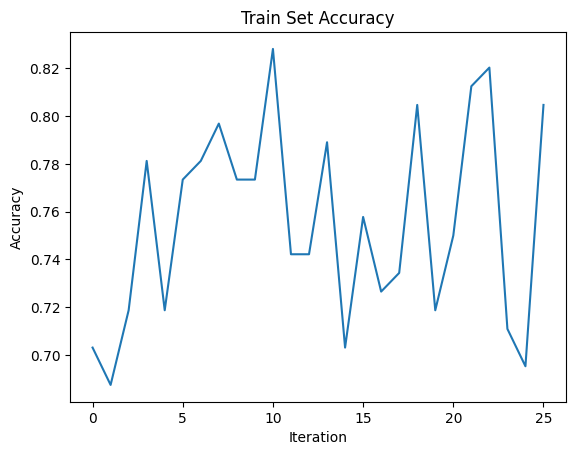

Epoch 1, Iteration 0 
Train Loss: 5.64
Accuracy: 78.91%

Epoch 1, Iteration 1 
Train Loss: 5.58
Accuracy: 75.78%

Epoch 1, Iteration 2 
Train Loss: 6.03
Accuracy: 75.78%

Epoch 1, Iteration 3 
Train Loss: 5.27
Accuracy: 76.56%

Epoch 1, Iteration 4 
Train Loss: 5.69
Accuracy: 77.34%

Epoch 1, Iteration 5 
Train Loss: 5.20
Accuracy: 83.59%

Epoch 1, Iteration 6 
Train Loss: 5.59
Accuracy: 75.00%

Epoch 1, Iteration 7 
Train Loss: 6.23
Accuracy: 75.78%

Epoch 1, Iteration 8 
Train Loss: 5.95
Accuracy: 74.22%

Epoch 1, Iteration 9 
Train Loss: 5.38
Accuracy: 78.91%

Epoch 1, Iteration 10 
Train Loss: 6.30
Accuracy: 72.66%

Epoch 1, Iteration 11 
Train Loss: 5.32
Accuracy: 82.81%

Epoch 1, Iteration 12 
Train Loss: 5.27
Accuracy: 82.03%

Epoch 1, Iteration 13 
Train Loss: 5.49
Accuracy: 85.16%

Epoch 1, Iteration 14 
Train Loss: 5.18
Accuracy: 77.34%

Epoch 1, Iteration 15 
Train Loss: 5.38
Accuracy: 78.91%

Epoch 1, Iteration 16 
Train Loss: 5.11
Accuracy: 85.94%

Epoch 1, Iteration 17 
T

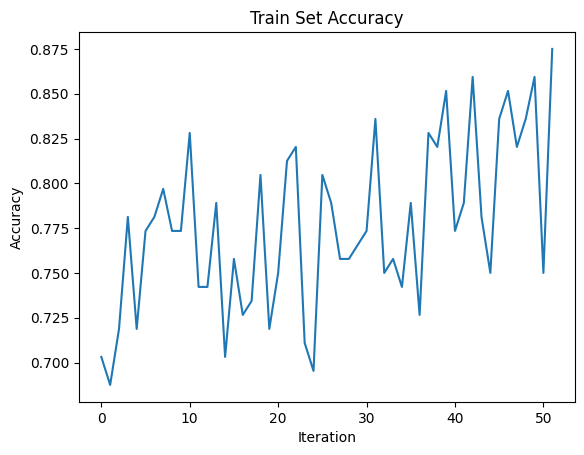

Epoch 2, Iteration 0 
Train Loss: 4.70
Accuracy: 83.59%

Epoch 2, Iteration 1 
Train Loss: 4.80
Accuracy: 83.59%

Epoch 2, Iteration 2 
Train Loss: 4.43
Accuracy: 87.50%

Epoch 2, Iteration 3 
Train Loss: 4.90
Accuracy: 82.81%

Epoch 2, Iteration 4 
Train Loss: 4.67
Accuracy: 81.25%

Epoch 2, Iteration 5 
Train Loss: 4.59
Accuracy: 85.16%

Epoch 2, Iteration 6 
Train Loss: 4.10
Accuracy: 86.72%

Epoch 2, Iteration 7 
Train Loss: 4.77
Accuracy: 85.94%

Epoch 2, Iteration 8 
Train Loss: 5.35
Accuracy: 84.38%

Epoch 2, Iteration 9 
Train Loss: 4.18
Accuracy: 85.16%

Epoch 2, Iteration 10 
Train Loss: 5.53
Accuracy: 82.03%

Epoch 2, Iteration 11 
Train Loss: 4.20
Accuracy: 86.72%

Epoch 2, Iteration 12 
Train Loss: 4.50
Accuracy: 89.06%

Epoch 2, Iteration 13 
Train Loss: 4.76
Accuracy: 84.38%

Epoch 2, Iteration 14 
Train Loss: 4.56
Accuracy: 87.50%

Epoch 2, Iteration 15 
Train Loss: 4.28
Accuracy: 87.50%

Epoch 2, Iteration 16 
Train Loss: 4.70
Accuracy: 80.47%

Epoch 2, Iteration 17 
T

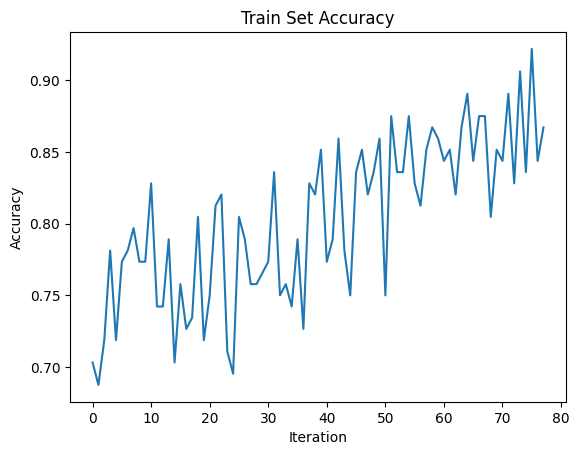

Epoch 3, Iteration 0 
Train Loss: 4.26
Accuracy: 85.94%

Epoch 3, Iteration 1 
Train Loss: 3.94
Accuracy: 90.62%

Epoch 3, Iteration 2 
Train Loss: 4.32
Accuracy: 85.16%

Epoch 3, Iteration 3 
Train Loss: 3.95
Accuracy: 86.72%

Epoch 3, Iteration 4 
Train Loss: 3.85
Accuracy: 85.94%

Epoch 3, Iteration 5 
Train Loss: 3.88
Accuracy: 88.28%

Epoch 3, Iteration 6 
Train Loss: 4.06
Accuracy: 86.72%

Epoch 3, Iteration 7 
Train Loss: 4.06
Accuracy: 84.38%

Epoch 3, Iteration 8 
Train Loss: 3.94
Accuracy: 90.62%

Epoch 3, Iteration 9 
Train Loss: 3.96
Accuracy: 86.72%

Epoch 3, Iteration 10 
Train Loss: 3.95
Accuracy: 85.94%

Epoch 3, Iteration 11 
Train Loss: 3.75
Accuracy: 91.41%

Epoch 3, Iteration 12 
Train Loss: 3.71
Accuracy: 89.06%

Epoch 3, Iteration 13 
Train Loss: 3.22
Accuracy: 94.53%

Epoch 3, Iteration 14 
Train Loss: 3.77
Accuracy: 87.50%

Epoch 3, Iteration 15 
Train Loss: 3.86
Accuracy: 85.16%

Epoch 3, Iteration 16 
Train Loss: 3.94
Accuracy: 88.28%

Epoch 3, Iteration 17 
T

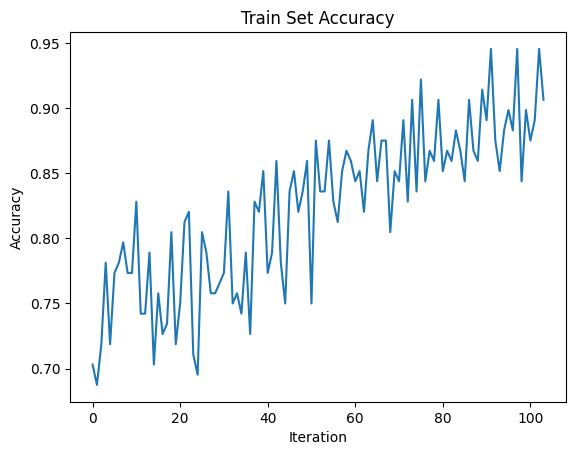

Epoch 4, Iteration 0 
Train Loss: 3.30
Accuracy: 91.41%

Epoch 4, Iteration 1 
Train Loss: 3.43
Accuracy: 91.41%

Epoch 4, Iteration 2 
Train Loss: 3.36
Accuracy: 90.62%

Epoch 4, Iteration 3 
Train Loss: 3.32
Accuracy: 92.97%

Epoch 4, Iteration 4 
Train Loss: 3.76
Accuracy: 84.38%

Epoch 4, Iteration 5 
Train Loss: 3.36
Accuracy: 93.75%

Epoch 4, Iteration 6 
Train Loss: 3.23
Accuracy: 89.06%

Epoch 4, Iteration 7 
Train Loss: 3.26
Accuracy: 93.75%

Epoch 4, Iteration 8 
Train Loss: 3.09
Accuracy: 93.75%

Epoch 4, Iteration 9 
Train Loss: 3.25
Accuracy: 87.50%

Epoch 4, Iteration 10 
Train Loss: 3.43
Accuracy: 86.72%

Epoch 4, Iteration 11 
Train Loss: 3.15
Accuracy: 90.62%

Epoch 4, Iteration 12 
Train Loss: 3.26
Accuracy: 90.62%

Epoch 4, Iteration 13 
Train Loss: 3.27
Accuracy: 87.50%

Epoch 4, Iteration 14 
Train Loss: 3.37
Accuracy: 93.75%

Epoch 4, Iteration 15 
Train Loss: 3.00
Accuracy: 92.97%

Epoch 4, Iteration 16 
Train Loss: 3.08
Accuracy: 92.19%

Epoch 4, Iteration 17 
T

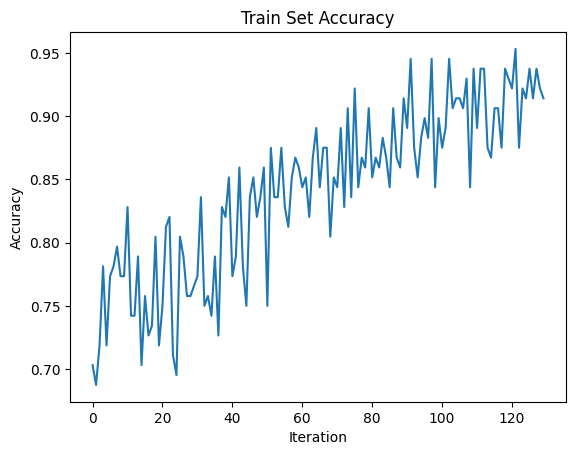

Epoch 5, Iteration 0 
Train Loss: 2.68
Accuracy: 93.75%

Epoch 5, Iteration 1 
Train Loss: 2.79
Accuracy: 96.09%

Epoch 5, Iteration 2 
Train Loss: 3.11
Accuracy: 90.62%

Epoch 5, Iteration 3 
Train Loss: 2.98
Accuracy: 91.41%

Epoch 5, Iteration 4 
Train Loss: 2.65
Accuracy: 94.53%

Epoch 5, Iteration 5 
Train Loss: 3.72
Accuracy: 87.50%

Epoch 5, Iteration 6 
Train Loss: 3.15
Accuracy: 88.28%

Epoch 5, Iteration 7 
Train Loss: 2.78
Accuracy: 95.31%

Epoch 5, Iteration 8 
Train Loss: 2.37
Accuracy: 95.31%

Epoch 5, Iteration 9 
Train Loss: 2.49
Accuracy: 94.53%

Epoch 5, Iteration 10 
Train Loss: 3.07
Accuracy: 92.19%

Epoch 5, Iteration 11 
Train Loss: 3.04
Accuracy: 92.19%

Epoch 5, Iteration 12 
Train Loss: 2.82
Accuracy: 95.31%

Epoch 5, Iteration 13 
Train Loss: 3.23
Accuracy: 86.72%

Epoch 5, Iteration 14 
Train Loss: 3.01
Accuracy: 90.62%

Epoch 5, Iteration 15 
Train Loss: 2.61
Accuracy: 95.31%

Epoch 5, Iteration 16 
Train Loss: 2.76
Accuracy: 93.75%

Epoch 5, Iteration 17 
T

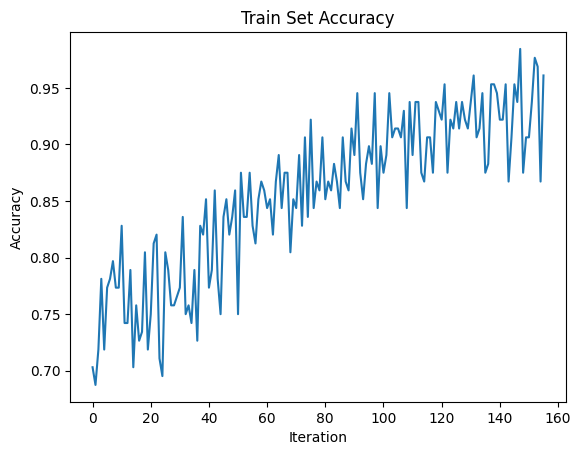

Epoch 6, Iteration 0 
Train Loss: 2.69
Accuracy: 92.19%

Epoch 6, Iteration 1 
Train Loss: 2.75
Accuracy: 92.97%

Epoch 6, Iteration 2 
Train Loss: 2.50
Accuracy: 92.19%

Epoch 6, Iteration 3 
Train Loss: 2.51
Accuracy: 95.31%

Epoch 6, Iteration 4 
Train Loss: 2.92
Accuracy: 91.41%

Epoch 6, Iteration 5 
Train Loss: 2.60
Accuracy: 89.84%

Epoch 6, Iteration 6 
Train Loss: 2.36
Accuracy: 92.97%

Epoch 6, Iteration 7 
Train Loss: 2.24
Accuracy: 96.88%

Epoch 6, Iteration 8 
Train Loss: 2.07
Accuracy: 96.88%

Epoch 6, Iteration 9 
Train Loss: 2.49
Accuracy: 93.75%

Epoch 6, Iteration 10 
Train Loss: 2.57
Accuracy: 92.97%

Epoch 6, Iteration 11 
Train Loss: 2.54
Accuracy: 92.19%

Epoch 6, Iteration 12 
Train Loss: 2.40
Accuracy: 95.31%

Epoch 6, Iteration 13 
Train Loss: 2.65
Accuracy: 92.97%

Epoch 6, Iteration 14 
Train Loss: 2.53
Accuracy: 90.62%

Epoch 6, Iteration 15 
Train Loss: 2.34
Accuracy: 94.53%

Epoch 6, Iteration 16 
Train Loss: 2.38
Accuracy: 95.31%

Epoch 6, Iteration 17 
T

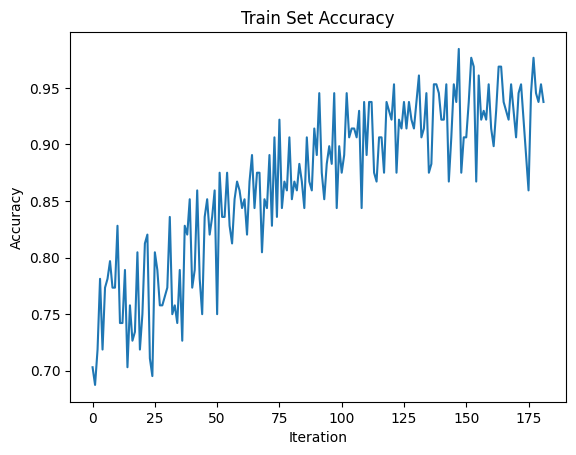

Epoch 7, Iteration 0 
Train Loss: 2.61
Accuracy: 93.75%

Epoch 7, Iteration 1 
Train Loss: 2.31
Accuracy: 96.09%

Epoch 7, Iteration 2 
Train Loss: 1.70
Accuracy: 99.22%

Epoch 7, Iteration 3 
Train Loss: 2.60
Accuracy: 91.41%

Epoch 7, Iteration 4 
Train Loss: 2.16
Accuracy: 95.31%

Epoch 7, Iteration 5 
Train Loss: 2.56
Accuracy: 92.19%

Epoch 7, Iteration 6 
Train Loss: 2.33
Accuracy: 91.41%

Epoch 7, Iteration 7 
Train Loss: 2.79
Accuracy: 92.97%

Epoch 7, Iteration 8 
Train Loss: 2.31
Accuracy: 93.75%

Epoch 7, Iteration 9 
Train Loss: 2.19
Accuracy: 95.31%

Epoch 7, Iteration 10 
Train Loss: 2.16
Accuracy: 93.75%

Epoch 7, Iteration 11 
Train Loss: 2.34
Accuracy: 94.53%

Epoch 7, Iteration 12 
Train Loss: 2.38
Accuracy: 94.53%

Epoch 7, Iteration 13 
Train Loss: 2.35
Accuracy: 92.97%

Epoch 7, Iteration 14 
Train Loss: 2.28
Accuracy: 94.53%

Epoch 7, Iteration 15 
Train Loss: 2.19
Accuracy: 96.09%

Epoch 7, Iteration 16 
Train Loss: 2.18
Accuracy: 95.31%

Epoch 7, Iteration 17 
T

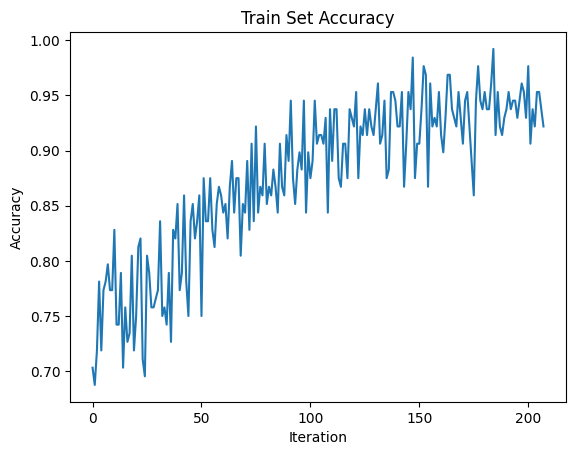

In [16]:
num_epochs = 8
num_iters = 25

loss_hist = []
acc_hist = []

def show(acc):
   # Plot Loss
  fig = plt.figure(facecolor="w")
  plt.plot(acc)
  plt.title("Train Set Accuracy")
  plt.xlabel("Iteration")
  plt.ylabel("Accuracy")
  plt.show()


# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

        # training loop breaks after 50 iterations
        if i == num_iters:
          break
    show(acc_hist)
import matplotlib.pyplot as plt

